In [1]:
import torch
import os, sys
import h5py
from models.genutils import *
from config import *
import numpy as np
from models.v2pca import *
from utils import *
import matplotlib
import matplotlib.pyplot as plt
from data_loader import matfile_dataload, h5py_dataload
from torch.optim import SGD
np.set_printoptions(suppress=True)
%matplotlib notebook
np.random.seed(5)

In [2]:
datadir  = '/scratch/np1742/texture-modeling/dat/'
outputdir = './output/'
imagefile = './cropped512-gray-jpg_40_5000.h5'
imarr1 = h5py.File(datadir+imagefile, 'r')['dat'][0:10000]
indsarr1 = h5py.File(datadir+imagefile, 'r')['inds'][0:10000]
wood = [4,18,39]
brick = [3,21]
stone = [0,20]
grass = [27,28,29] 
#32,33]
total_inds = [4,18,39,3,21,0,20,27,28,29]
texturetypedict = {'wood': wood, 'brick': brick, 'stone': stone, 'grass': grass, 'all': total_inds}
dimreduce_type = 'geneig'

matdata = matfile_dataload(rawdat = True)
window = np.array(matdata['data'][0][0]['f'][0][0]['coeffWeights'])
windowbool = np.array(matdata['data'][0][0]['f'][0][0]['coeffIndex'])[:,0]
windowinds = np.nonzero(windowbool)[0]
window = torch.tensor(window, dtype=dtype).to(device)




In [3]:


if dimreduce_type == 'pca':
    weightfile = outputdir + 'pcamat.h5'
    componentfile =  outputdir + 'pcamat_componenttest_40_5000_10000.h5'
elif dimreduce_type == 'geneig':
    weightfile = outputdir + 'geneigtransform_40_5000.h5'
    componentfile = outputdir + 'geneigtransform_40_5000_componenttest_40_5000_10000.h5'

    
def get_texture_type(componentfile, texture_type, texturetypedict):
    x = h5py.File(componentfile, 'r')['dat'][()]
    imlist = texturetypedict[texture_type]
    for i in range(len(imlist)):
        n = imlist[i]
        indsval = np.where(indsarr1 == n)[0]
        xout = x[indsval,:]
        imtmp = imarr1[indsval]
        indstmp = indsarr1[indsval]
        if i == 0:
            imarr = imtmp
            xarr = xout
            indsarr = indstmp
        else:
            imarr = np.concatenate((imarr, imtmp), axis=0)
            indsarr = np.concatenate((indsarr,indstmp))
            xarr = np.concatenate((xarr,xout), axis=0)
    
    if texture_type is not 'all':
        covarr = np.cov(xarr.T)
        meanarr = np.mean(xarr, axis=0)
        mvn = torch.distributions.multivariate_normal.MultivariateNormal(torch.tensor(meanarr, dtype=dtype), torch.tensor(covarr, dtype=dtype))
    else:
        mvn = None
    
    return imarr, xarr, mvn, indsarr


grassim, grasstext,mvngrass, grassinds = get_texture_type(componentfile, 'grass', texturetypedict)
brickim, bricktext, mvnbrick, brickinds = get_texture_type(componentfile, 'brick', texturetypedict)
woodim, woodtext, mvnwood, woodinds, = get_texture_type(componentfile, 'wood', texturetypedict)
stoneim, stonetext, mvnstone, stoneinds = get_texture_type(componentfile, 'stone', texturetypedict)
allim, alltext, _, allinds = get_texture_type(componentfile, 'all', texturetypedict)


print(grasstext.shape)
print(grassim.shape)
print(allinds[0:20])

(754, 10)
(754, 64, 64)
[4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]


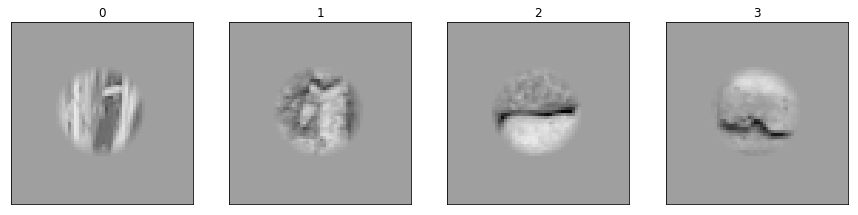

In [4]:
fig, axs = plt.subplots(1,4, figsize=(15,5))
ims = [grassim[2,:,:], woodim[2,:,:], stoneim[2,:,:], brickim[2,:,:]]
minval = min([im.min() for im in ims])
maxval = max([im.max() for im in ims])
for i in range(4):
    im = window_im(ims[i], window)
    axs[i].imshow(im, cmap='gray', vmin=minval, vmax = maxval)
    axs[i].set_title(str(i))
    axs[i].xaxis.set_visible(False)
    axs[i].yaxis.set_visible(False)
    
plt.show()

Text(0,0.5,'LL of Sample w.r.t Grass Dist')

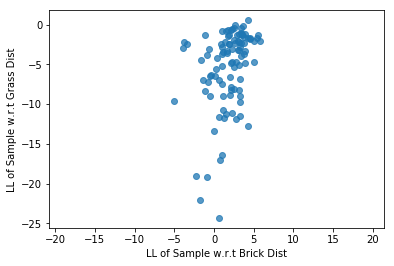

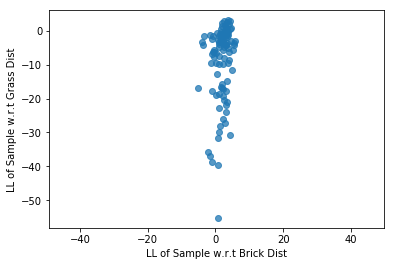

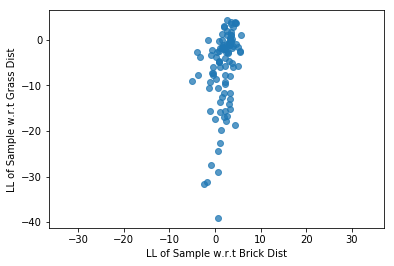

In [5]:
samps = mvnbrick.rsample(torch.Size((100,1)))
log_prob_brick = mvnbrick.log_prob(samps)
log_prob_grass = mvngrass.log_prob(samps)
log_prob_wood = mvnwood.log_prob(samps)
log_prob_stone = mvnstone.log_prob(samps)
plt.figure()
plt.scatter(log_prob_brick.data.numpy(), log_prob_grass.data.numpy(),alpha=0.75)
plt.axis('equal')
plt.xlabel('LL of Sample w.r.t Brick Dist')
plt.ylabel('LL of Sample w.r.t Grass Dist')
plt.figure()
plt.scatter(log_prob_brick.data.numpy(), log_prob_wood.data.numpy(),alpha=0.75)
plt.axis('equal')
plt.xlabel('LL of Sample w.r.t Brick Dist')
plt.ylabel('LL of Sample w.r.t Grass Dist')
plt.figure()
plt.scatter(log_prob_brick.data.numpy(), log_prob_stone.data.numpy(),alpha=0.75)
plt.axis('equal')
plt.xlabel('LL of Sample w.r.t Brick Dist')
plt.ylabel('LL of Sample w.r.t Grass Dist')



In [6]:
def loss_fn(out, target):
    loss = torch.sum(torch.mean((out-target)**2))
    return loss

def texture_gradsynth(x, network, targvec, print_iters=400):
    """
    For a given network and input image x, optimize the pixels in x such that the output
    component values match a specified vector -- return imagelist for every 
    Generate num_steps gradient steps and return the image list
    """
    imagelist = []
    complist = []
    output_orig = network(x.clone())
    optimizer = SGD([x],lr=0.02, momentum = 0.9)
    printout(str(targvec.data.cpu().numpy()))
    for i in range(2000):
        #renormalize images to mean 0 std 1 before next gradient step
        x.data = (x.data-x.data.mean())/x.data.std()
        optimizer.zero_grad()
        output = network(x)
        loss = loss_fn(output, targvec)
        loss.backward(retain_graph=True)
        if i %print_iters ==0:
            outtmp = output.clone()
            outtmpnp = outtmp.detach().data.cpu().numpy()
            printout("Component Vector: " + str(np.around(outtmpnp, decimals=2)))
            print("Total Loss " + str(loss.data.cpu().numpy()))
            complist.append(np.around(outtmpnp,decimals=2))
            imagelist.append(x.clone())

        optimizer.step()

    return imagelist, complist

def run_gradsynth(weightfile,textclassarr, savepath = './output/', dataset = 'lcv', num_textures = 40, max_patches=5000, use_window=True):
    matdata = matfile_dataload(rawdat = True)
    if use_window:
        window = np.array(matdata['data'][0][0]['f'][0][0]['coeffWeights'])
        windowbool = np.array(matdata['data'][0][0]['f'][0][0]['coeffIndex'])[:,0]
        windowinds = np.nonzero(windowbool)[0]
        window = torch.tensor(window, dtype=dtype).to(device)
    else:
        window = None
        
    del matdata
    imsize = 64
    h5f = h5py.File(weightfile, 'r')
    weights = h5f['dat'][()][:,0:11]
    weights = torch.tensor(weights, dtype=dtype).to(device)
    network = V2PCA(imgSize=imsize, K=4, N=2, nonlin='smoothabs', window = window, pcaMat = weights, ret_pyr = False, ncomp=11)
    
    printout("Network and data loaded....")
    
    impatches = []
    
    wn_image = np.random.randn(imsize, imsize)
    
    randnum = np.random.randint(0, textclassarr.shape[0])
    targcomp = torch.tensor(textclassarr[randnum,:], dtype=dtype).to(device)
    im = wn_image
    x = torch.tensor(im.reshape([1,1,im.shape[0], im.shape[1]]), dtype=dtype).to(device)
    x.requires_grad_()
    imagelist, complist = texture_gradsynth(x, network, targcomp)
    return imagelist, complist

synthlist1, complist = run_gradsynth(weightfile, woodtext)
synthlist2, complist = run_gradsynth(weightfile, stonetext)
synthlist3, complist = run_gradsynth(weightfile, bricktext)
synthlist4, complist = run_gradsynth(weightfile, grasstext)

Network and data loaded....
[-3.6035733  -1.6497178  -9.12376     0.7953752  -7.5702906  -3.1442118
  0.39945084  3.455094   -0.62643504  1.5164032 ]
Component Vector: [[-5.25 -0.48 -6.14  0.78 -7.68 -2.22  1.01  3.17 -0.65  1.17]]
Total Loss 1.438891
Component Vector: [[-4.6  -1.67 -8.64  0.88 -7.63 -3.08  0.59  3.32 -0.64  1.3 ]]
Total Loss 0.13438252
Component Vector: [[-4.06 -1.73 -8.93  0.76 -7.57 -3.2   0.49  3.42 -0.58  1.28]]
Total Loss 0.032539953
Component Vector: [[-3.85 -1.74 -9.02  0.72 -7.56 -3.24  0.45  3.45 -0.56  1.29]]
Total Loss 0.014852166
Component Vector: [[-3.76 -1.74 -9.06  0.71 -7.55 -3.24  0.43  3.47 -0.55  1.32]]
Total Loss 0.009717907
Network and data loaded....
[-1.9977822  -0.5716959  -3.2341266   0.66449934 -3.9427295  -1.1778281
  0.47574544  2.1410587  -0.21231794  0.61998403]
Component Vector: [[-5.56 -0.77 -5.87  1.3  -7.5  -1.93  1.06  3.27 -0.56  1.36]]
Total Loss 3.5622115
Component Vector: [[-2.67 -0.42 -3.01  0.74 -3.95 -1.09  0.52  1.98 -0.22  0

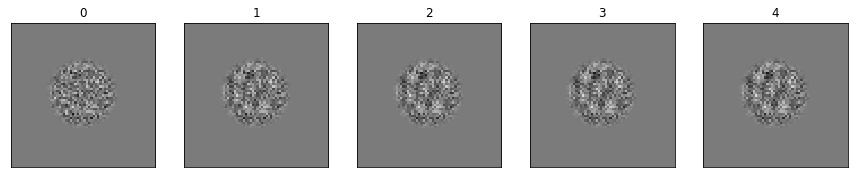

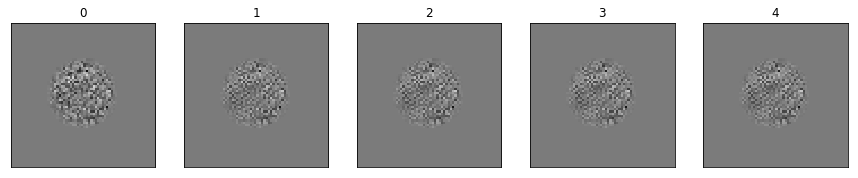

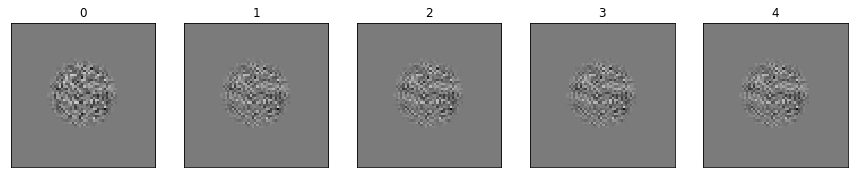

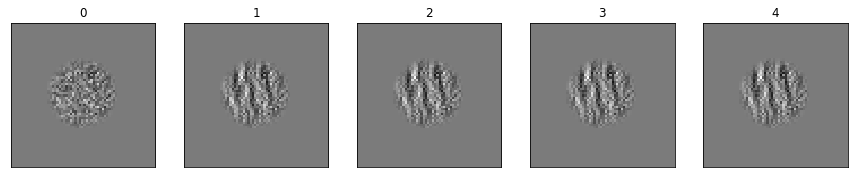

In [13]:
import pyrtools as pt
synthlists = [synthlist1, synthlist2, synthlist3, synthlist4]
matdata = matfile_dataload(rawdat = True)
window = np.array(matdata['data'][0][0]['f'][0][0]['coeffWeights'])
windowbool = np.array(matdata['data'][0][0]['f'][0][0]['coeffIndex'])[:,0]
windowinds = np.nonzero(windowbool)[0]
window = torch.tensor(window, dtype=dtype).to(device)

for synthlist in synthlists:
    #minval = min([im.min().data.cpu().numpy() for im in synthlist])
    #maxval = max([im.max().data.cpu().numpy() for im in synthlist])
    fig, axs = plt.subplots(1,5, figsize=(15,10))

    for i in range(len(synthlist)):
        im = window_im(synthlist[i].data.cpu().numpy().reshape((64,64)), window)
        xind = int(np.floor(i/5))
        yind = int(i%5)
        axs[i].imshow(im, cmap='gray', vmin=minval, vmax = maxval)
        axs[i].set_title(str(i))
        axs[i].xaxis.set_visible(False)
        axs[i].yaxis.set_visible(False)

    plt.show()
    


In [14]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
n_clusters = 4
clusterer = KMeans(n_clusters = n_clusters, random_state = 10)
cluster_labels = clusterer.fit_predict(alltext)

In [15]:

cluster_labels[300:600]

array([0, 0, 2, 0, 3, 2, 2, 0, 0, 2, 0, 0, 0, 2, 3, 0, 3, 3, 0, 0, 0, 2,
       0, 0, 3, 2, 2, 0, 0, 2, 3, 2, 3, 0, 2, 0, 0, 0, 0, 2, 0, 3, 1, 0,
       2, 2, 3, 2, 0, 2, 0, 2, 0, 2, 0, 0, 0, 3, 2, 0, 2, 3, 0, 2, 2, 0,
       2, 0, 0, 3, 2, 0, 2, 0, 2, 0, 0, 0, 3, 3, 0, 3, 3, 1, 0, 0, 0, 3,
       0, 0, 2, 1, 2, 0, 2, 3, 0, 0, 3, 3, 3, 0, 3, 0, 0, 0, 0, 2, 3, 0,
       2, 2, 0, 3, 2, 3, 2, 0, 3, 0, 3, 2, 2, 3, 2, 3, 0, 3, 2, 3, 1, 0,
       0, 1, 0, 0, 0, 2, 2, 2, 3, 0, 2, 1, 0, 3, 2, 0, 2, 0, 2, 2, 2, 3,
       2, 2, 2, 0, 3, 3, 2, 0, 0, 2, 3, 0, 2, 3, 3, 2, 2, 0, 0, 0, 1, 2,
       2, 2, 3, 3, 0, 2, 0, 0, 0, 0, 0, 3, 3, 2, 0, 1, 3, 3, 2, 2, 2, 2,
       2, 2, 0, 2, 3, 2, 2, 0, 0, 3, 2, 2, 2, 2, 3, 2, 3, 0, 0, 2, 0, 3,
       0, 3, 2, 3, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 2, 3, 2, 2, 2, 0, 2, 2,
       2, 3, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 2, 2, 2, 2, 3, 2, 0, 2, 2,
       2, 0, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 0, 2, 3, 2, 2, 0, 2, 0,
       0, 0, 3, 0, 0, 3, 3, 2, 3, 2, 2, 3, 0, 0], d

In [10]:
total_inds = [4,18,39,3,21,0,20,27,28,29]
allinds[allinds==4] = 4
allinds[allinds==18] = 4
allinds[allinds==39]=4
allinds[allinds==3] = 3
allinds[allinds==21] = 3
allinds[allinds==0]=2
allinds[allinds==20]=2
allinds[allinds==27] = 1
allinds[allinds==28]=1
allinds[allinds==29]=1
print(allinds[0])
print(allinds[1000])
print(allinds[1600])
print(allinds[2000])

4
3
2
1


In [19]:
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=5, algorithm = 'ball_tree').fit(alltext)
distances, indices = nbrs.kneighbors(alltext)
indices

array([[   0,   17, 2339,  154,  225],
       [   1,  788,  162,  198,   12],
       [   2,   12, 2340, 2203, 2165],
       ...,
       [2515, 1785, 2416, 1423, 2232],
       [2516, 2283,  502,  379,  399],
       [2517, 1850, 1846, 1815, 1535]])

[0.         0.44759697 0.46448238 0.49822536 0.50580046]


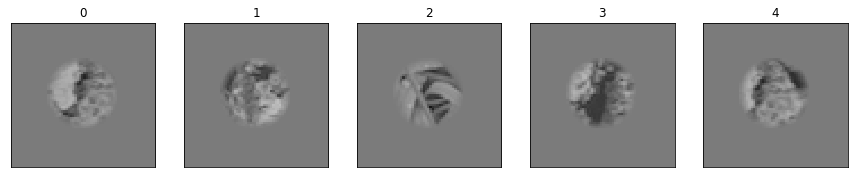

[0.         0.27753125 0.44250948 0.44543439 0.47966521]


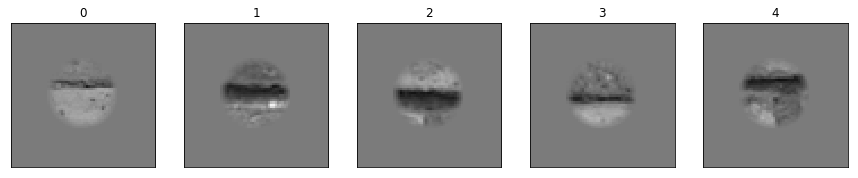

[0.         0.32190399 0.33178023 0.36453221 0.38312489]


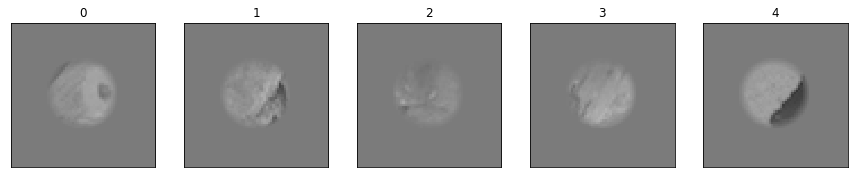

[0.         0.5961721  0.65319257 0.66223944 1.02999347]


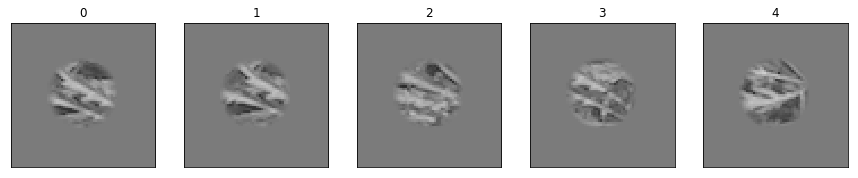

In [20]:

randints= [0,1000,1600, 2200]
for k in range(len(randints)):
    l = randints[k]
    fig, axs = plt.subplots(1,5, figsize=(15,5))
    print(distances[l])

    for i in range(5):
        im = window_im(allim[indices[l][i]], window)
        xind = int(np.floor(i/5))
        yind = int(i%5)
        axs[i].imshow(im, cmap='gray', vmin=minval, vmax = maxval)
        axs[i].set_title(str(i))
        axs[i].xaxis.set_visible(False)
        axs[i].yaxis.set_visible(False)

    plt.show()